In [ ]:
train_dataset = '/content/train.csv'
test_dataset = '/content/test.csv'

In [ ]:
import pandas as pd
train_data = pd.read_csv(train_dataset, encoding='ISO-8859-1')
test_data = pd.read_csv(test_dataset,encoding="ISO-8859-1")
data = pd.concat([train_data,test_data])

In [ ]:
data.head()

,textID,text,selected_text,sentiment,Time of Tweet,Age of User,Country,Population -2020,Land Area (Km²),Density (P/Km²)
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,morning,0-20,Afghanistan,38928346.0,652860.0,60.0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,noon,21-30,Albania,2877797.0,27400.0,105.0
2,088c60f138,my boss is bullying me...,bullying me,negative,night,31-45,Algeria,43851044.0,2381740.0,18.0
3,9642c003ef,what interview! leave me alone,leave me alone,negative,morning,46-60,Andorra,77265.0,470.0,164.0
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,noon,60-70,Angola,32866272.0,1246700.0,26.0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 32296 entries, 0 to 4814
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   textID            31015 non-null  object 
 1   text              31014 non-null  object 
 2   selected_text     27480 non-null  object 
 3   sentiment         31015 non-null  object 
 4   Time of Tweet     31015 non-null  object 
 5   Age of User       31015 non-null  object 
 6   Country           31015 non-null  object 
 7   Population -2020  31015 non-null  float64
 8   Land Area (Km²)   31015 non-null  float64
 9   Density (P/Km²)   31015 non-null  float64
dtypes: float64(3), object(7)
memory usage: 2.7+ MB


In [ ]:
data.dropna(inplace=True)

In [ ]:
final_corpus = data['text'].astype(str).tolist()
data_eda = pd.DataFrame()
data_eda['text'] = final_corpus
data_eda['sentiment'] = data["sentiment"].values
data_eda.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
import string
import re
def wp(text):
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text
data_eda['text'] = data_eda["text"].apply(wp)

In [ ]:
data_eda

,text,sentiment
0,Id have responded if I were going,neutral
1,Sooo SAD I will miss you here in San Diego,negative
2,my boss is bullying me,negative
3,what interview leave me alone,negative
4,Sons of why couldnt they put them on the rel...,negative
...,...,...
27475,wish we could come see u on Denver husband l...,negative
27476,Ive wondered about rake to The client has ma...,negative
27477,Yay good for both of you Enjoy the break you...,positive
27478,But it was worth it,positive


In [ ]:
data_eda.to_csv("data_eda.csv", index=False)

In [ ]:
data_eda['sentiment_code'] = data_eda['sentiment'].astype('category').cat.codes

In [ ]:
X=data_eda['text']
y= data_eda['sentiment_code']

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()

In [ ]:
tokenizer.fit_on_texts(X)

In [ ]:
input_sequences = []
for sentence in X:
    tokenized_sentence = tokenizer.texts_to_sequences([sentence])[0]
    input_sequences.append(tokenized_sentence)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
MAX_LENGTH = max([len(x) for x in input_sequences])
print(MAX_LENGTH)

32


In [ ]:
enocoder_input = pad_sequences(input_sequences, maxlen=MAX_LENGTH, padding='pre')

In [ ]:
# Define vocab_size
vocab_size = len(tokenizer.word_index) + 1  # Vocabulary size based on tokenizer
embedding_dim = 128  # Dimension of embedding vectors
max_length = 32  # Use the computed MAX_LENGTH
num_classes = len(data_eda['sentiment_code'].unique())  # Number of unique sentiment categories


In [ ]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Convert target labels to categorical format (one-hot encoding)
y = to_categorical(data_eda['sentiment_code'])

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(enocoder_input, y, test_size=0.2, random_state=42)


In [ ]:
from tensorflow.keras.models import Sequential  # Import Sequential model
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, BatchNormalization

# Updated CNN model
model = Sequential([
    # Embedding layer
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),

    # 1st Convolutional Block
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    Dropout(0.5),

    # 2nd Convolutional Block
    Conv1D(filters=128, kernel_size=5, activation='relu', padding='same'),
    BatchNormalization(),
    GlobalMaxPooling1D(),

    # Fully Connected Layers
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),

    # Output Layer
    Dense(num_classes, activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train model with validation accuracy
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=32)

# Predicting on test set
y_pred = model.predict(X_val)
y_pred_classes = y_pred.argmax(axis=-1)

# Check model summary
model.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.3756 - loss: 1.2124 - val_accuracy: 0.5389 - val_loss: 0.9798
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.5637 - loss: 0.9116 - val_accuracy: 0.7147 - val_loss: 0.7376
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7464 - loss: 0.6268 - val_accuracy: 0.7140 - val_loss: 0.6938
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8143 - loss: 0.4743 - val_accuracy: 0.7058 - val_loss: 0.7441
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.8664 - loss: 0.3688 - val_accuracy: 0.7011 - val_loss: 0.7673
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8895 - loss: 0.2993 - val_accuracy: 0.7052 - val_loss: 0.8286
Epoch 7/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.9129 - loss: 0.2441 - val_accuracy: 0.6980 - val_loss: 0.8914
Epoch 8/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.9284 - loss: 0.2046 - val_accuracy: 0

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (32, 32, 128)               │       3,396,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ (32, 32, 128)               │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (32, 32, 128)               │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (32, 32, 128)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (32, 32, 128)               │          82,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (32, 32, 128)               │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ (32, 128)                   │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (32, 128)                   │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (32, 128)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 64)                    │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (32, 3)                     │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,759,435 (41.04 MB)

 Trainable params: 3,586,307 (13.68 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 7,172,616 (27.36 MB)

In [ ]:
# Evaluate the model on the validation set
loss, accuracy = model.evaluate(X_val, y_val, verbose=0)

# Print the accuracy
print(f"Model Accuracy: {accuracy * 100:.2f}%")



Model Accuracy: 67.85%


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
Neutral 😐: [confidence - 99.20%]


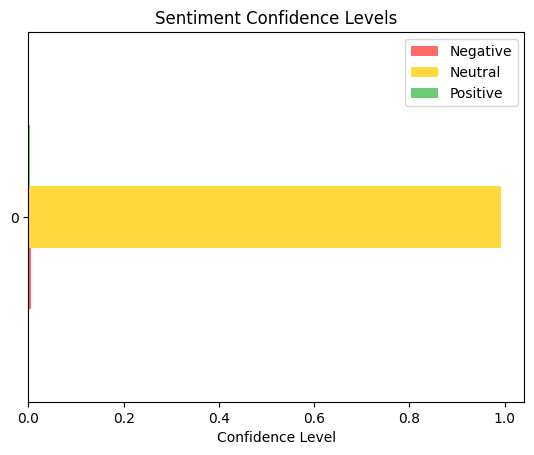

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

def SentimentAnalysis(text):
    # Tokenize and pad the input text
    sentence = [text]
    tokenized_sentence = tokenizer.texts_to_sequences(sentence)
    input_sequence = pad_sequences(tokenized_sentence, maxlen=MAX_LENGTH, padding='pre')

    # Make prediction
    prediction_ = model.predict(input_sequence)
    prediction = prediction_.argmax()

    # Print prediction with confidence level
    if prediction == 0:
        print(f"Negative 😠: [confidence - {prediction_[0][0] * 100:.2f}%]")
    elif prediction == 1:
        print(f"Neutral 😐: [confidence - {prediction_[0][1] * 100:.2f}%]")
    else:
        print(f"Positive 😊: [confidence - {prediction_[0][2] * 100:.2f}%]")

    # Plot confidence levels for each sentiment class
    plot = pd.DataFrame(prediction_, columns=['Negative', 'Neutral', 'Positive'])
    plot.plot(kind='barh', color=['#FF6B6B', '#FFD93D', '#6BCB77'])
    plt.xlabel('Confidence Level')
    plt.title('Sentiment Confidence Levels')
    plt.show()

# Example usage
SentimentAnalysis("i dont know")


In [ ]:
from sklearn.metrics import classification_report, accuracy_score

# Define class names for sentiment categories
class_names = ['Negative', 'Neutral', 'Positive']

# Convert one-hot encoded y_val back to class labels
y_val_classes = y_val.argmax(axis=-1)

# Generate classification report
report = classification_report(y_val_classes, y_pred_classes, target_names=class_names, digits=4)

# Print classification metrics
print("Classification Report:")
print(report)

# Calculate and print overall accuracy
accuracy = accuracy_score(y_val_classes, y_pred_classes)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")

Classification Report:
              precision    recall  f1-score   support

    Negative     0.7042    0.5693    0.6296      1572
     Neutral     0.6150    0.7379    0.6709      2236
    Positive     0.7678    0.7014    0.7331      1688

    accuracy                         0.6785      5496
   macro avg     0.6957    0.6696    0.6779      5496
weighted avg     0.6874    0.6785    0.6782      5496

Overall Accuracy: 67.85%
